# ASTR 596 Computer lab - Image combination and photometry (35 points)

In this lab you will learn how to:
* combine a set of astrometrically aligned images
* measure the size of stars in each of these images
* measure fluxes of objects in each image
* convert these to magnitudes
* match sources in the two catalogs
* plot H-R diagrams for the cluster

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on Nov. 8 at Noon** to be handed into the "Image Combinaton and Photometry" assignment in Module 7.

Thanks to Prof. Rose Finn for her work in reducing the individual images of M29 and for providing them to us.

You will need to download the raw data.  You can access it at https://www.dropbox.com/t/KLcvlNUMTsSWhmtD 

I suggest you make a directory on your computer called `~/ASTR596/Data` and put data in there.  

In [2]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile

from matplotlib import pyplot as plt
import numpy as np

#import ccdproc

from astropy.nddata import CCDData
import astropy.units as u
from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project


### Some functions to display the images and overplot the stars

In [3]:
def imdisplay(image, v1perc=10, v2perc=95):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    plt.imshow(nimage,cmap='gray_r',vmin=v1,vmax=v2)
    plt.colorbar(fraction=.08)
    
def add_stars(xstars,ystars,radius=20,color='r',ax=None):
    ''' this will add circles at the location of xstars,ystars '''
    if ax is None:
        ax = plt.gca()
    allcircles=[]
    #The zip function takes iterables (e.g. lists or arrays) and groups them into tuples that contain 
    #matched pairs of each input, e.g [(x,y)]
    for x,y in zip(xstars,ystars):
        c = plt.Circle((x,y),radius,color=color,fill=False)
        #allcircles.append(c)
        ax.add_artist(c)

In [4]:
#set the directory with your data
#*********************
#you will need to modify this with your own directory
datadir = '/home/c413a612/ASTR596/Data/M29_cal'
os.chdir(datadir)


### Display one image in each filter 
This will let you see what the data in each filter looks like

Text(0.5, 1.0, 'B-band image')

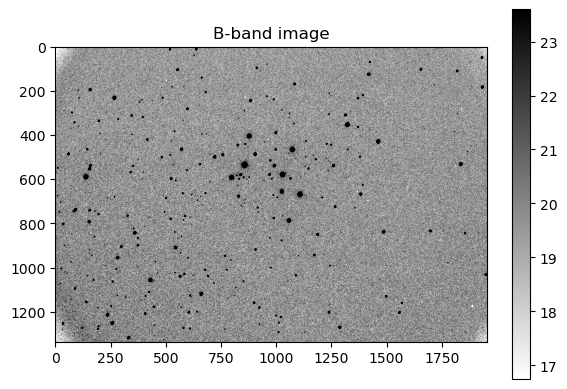

In [5]:
plt.figure()
data,header = fits.getdata('cazfdp-M29-0001b.fits', header=True)
imdisplay(data)
plt.title("B-band image")

Text(0.5, 1.0, 'V-band image')

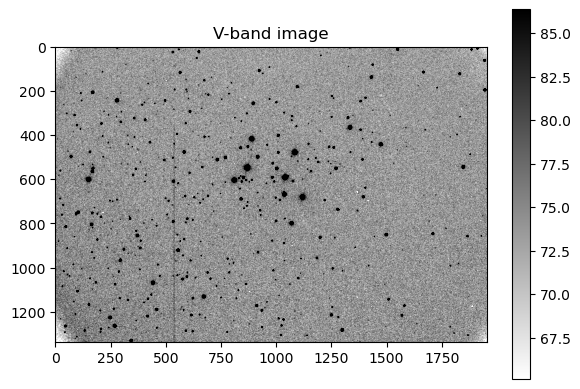

In [6]:
plt.figure()
data,header = fits.getdata('cazfdp-M29-0001g.fits', header=True)
imdisplay(data)
plt.title("V-band image")

Text(0.5, 1.0, 'R-band image')

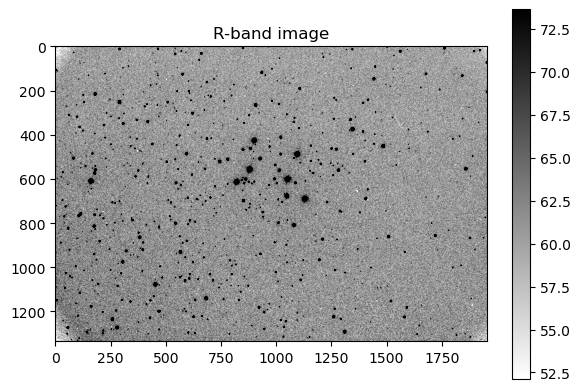

In [7]:
plt.figure()
data,header = fits.getdata('cazfdp-M29-0001r.fits', header=True)
imdisplay(data)
plt.title("R-band image")

### determine how subsequent images in a single band differ

Use ds9 to display the 0001, 0002, and 0003 images for the $B$ band.  Display each image in a separate frame by creating a new frame in the horizontal button bar and opening the file into that frame.  Use the `scale->zscale` button to display the stretch better.

By hitting the Tab key you can cycle through the images.  Shift-Tab cycles through them in reverse order.  You can also use the Blink button or the Tile button under the Frame button to blink the images.

### Problem 1 (5 points)
What is the main difference between the individual images within a single band?

The main difference betweent the three frames that the position of the stars changes between each frame changes location. Another difference is how bright the images are after Z - scaling. There is a sequential image from 0001,0002,0003 that changes on how intense the light is where 0001 is the dimmest and 0003 has the brightest. You can see this throught the amount of counts. The scaling is different between 1 and 3 where the scaling for 1 has the lowest value of 16 and for 3, the lowest value is 13. The highest value for 0001 is 33 and 36 respectively for 00003

### Combine the images in each filter.

Reference: https://ccdproc.readthedocs.io/en/latest/image_combination.html

Note: $BVR$ images have extensions $bgr$ in our data set.  These images have had their bias correction, dark current, flatfielding, astrometry, and photometric zeropoint all measured and have had cosmicrays removed.

We will use a new task called `glob.glob` which finds all the files in a current directory that match a certain syntax.

The image combination has multiple steps
* get a list of the images in each band.  
* Each image has a slightly different pointing because the telescope was dithered around.
* establish which WCS you will use as a target onto which all the other images will be aligned.
* use a task called `reproject` to align all of the images using the reference 

In [8]:
#for example, to get a list of all the images
image_list = glob.glob('ca*.fits')
print(image_list)

['cazfdp-M29-0005g.fits', 'cazfdp-M29-0002b.fits', 'cazfdp-M29-0004r.fits', 'cazfdp-M29-0003g.fits', 'cazfdp-M29-0004g.fits', 'cazfdp-M29-0005r.fits', 'cazfdp-M29-0002g.fits', 'cazfdp-M29-0001r.fits', 'cazfdp-M29-0001g.fits', 'cazfdp-M29-0004b.fits', 'cazfdp-M29-0003b.fits', 'cazfdp-M29-0005b.fits', 'cazfdp-M29-0003r.fits', 'cazfdp-M29-0001b.fits', 'cazfdp-M29-0002r.fits']


In [9]:
#*****************
#Using the above code as a reference, create lists of images in each band
#First we need to get a list for images in each filter
rimage_list = glob.glob('ca*r.fits')
gimage_list = glob.glob('ca*g.fits')
bimage_list = glob.glob('ca*b.fits')

#read in the first r-band image in that list using fits.getdata.  This image will be used as a target whose WCS
# will be used for all other images to be transformed onto
rimage, rheader = fits.getdata(rimage_list[0],header=True)
target_wcs = WCS(header)

print(target_wcs)
#**********************
#now print out each of the image lists to see if they make sense
print(rimage_list)
print(gimage_list)
print(bimage_list)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 305.979554574  38.5221094171  
CRPIX : 977.5  668.5  
CD1_1 CD1_2  : 0.000213779024462  -6.70567456134e-05  
CD2_1 CD2_2  : 6.71084281872e-05  0.000213787720685  
NAXIS : 1954  1336
['cazfdp-M29-0004r.fits', 'cazfdp-M29-0005r.fits', 'cazfdp-M29-0001r.fits', 'cazfdp-M29-0003r.fits', 'cazfdp-M29-0002r.fits']
['cazfdp-M29-0005g.fits', 'cazfdp-M29-0003g.fits', 'cazfdp-M29-0004g.fits', 'cazfdp-M29-0002g.fits', 'cazfdp-M29-0001g.fits']
['cazfdp-M29-0002b.fits', 'cazfdp-M29-0004b.fits', 'cazfdp-M29-0003b.fits', 'cazfdp-M29-0005b.fits', 'cazfdp-M29-0001b.fits']


###  Combine the images

Text(0.5, 1.0, 'R-band image')

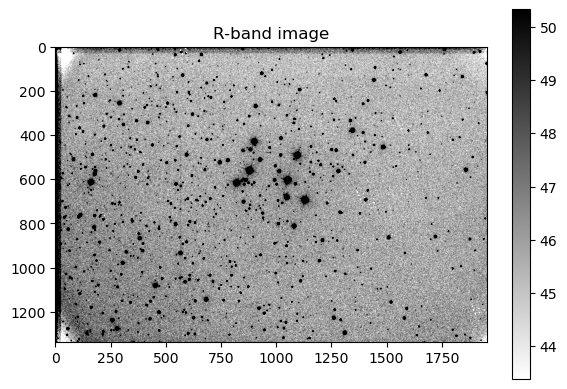

In [10]:
# We will reproject all the images to align them with the first image in the R-band list.
#start with the R-band data
reprojected = []
#loop through each image name
for image_name in rimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29R.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('R-band image')

## Problem 2 (5 points)

/home/c413a612/.conda/envs/stenv/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/c413a612/.conda/envs/stenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'G-band image')

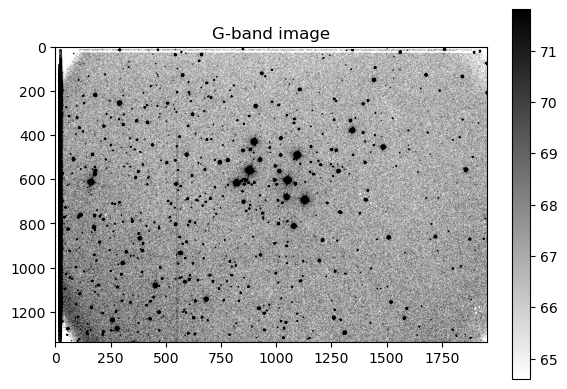

In [11]:
#*********************
#repeat for the V-band images
# We will reproject all the images to align them with the first image in the R-band list.
#start with the R-band data
reprojected = []
#loop through each image name
for image_name in gimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29G.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('G-band image')

/home/c413a612/.conda/envs/stenv/lib/python3.10/site-packages/ccdproc/combiner.py:556: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/c413a612/.conda/envs/stenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'B-band image')

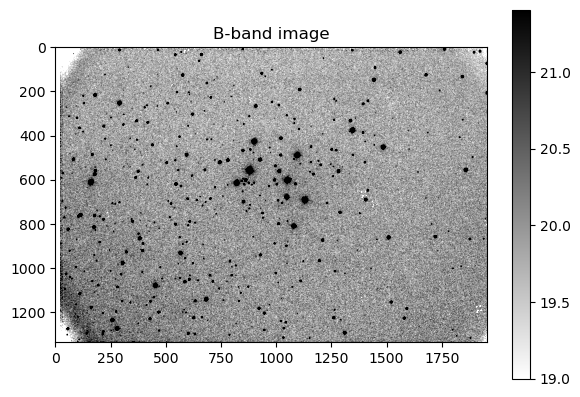

In [12]:
#*********************
#repeat for the B-band images
# We will reproject all the images to align them with the first image in the R-band list.
#start with the R-band data
reprojected = []
#loop through each image name
for image_name in bimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29B.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('B-band image')

### What if we want to display our images using RA and DEC?

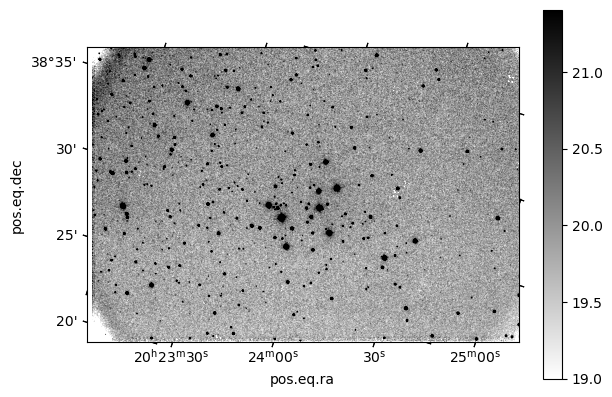

In [13]:
plt.subplot(projection=target_wcs)
imdisplay(stacked_image)

## Problem 3 - Measure the FWHM of stars using imexam (5 points)

imexam is a powerful image quick look tool to examine the images.  More info is at https://imexam.readthedocs.io/en/0.9.1/index.html

As it is a finiky package, to use it we will need to make a new environment.  You should do so with the following command from a new prompt that is in your base conda environment:

<font color=red>conda create --name env1 python==3.10.12 astropy==5.2.2 astroplan astroquery jupyter imexam ccdproc --channel conda-forge --solver libmamba</font>

In at terminal in the same directory as your data type `ipython`.  At the ipython command line type the following commands, each on their own line
* import imexam
* viewer=imexam.connect()   #start a ds9 window
* viewer.load_fits('M29B.fits')  #loads an image
* viewer.scale()   #change to the default zscale
* viewer.imexam() #start the interactive tool.

You will see a set of cursor commands.  By putting the cursor over a star in the image and hitting the `a` key you will get a measure of the size and flux in the image.  

Do this for 5 stars and take the average to get the FWHM of your image. 


Fill in those values below


FWHM of B-band image (in pix): (4.27, 4.62, 4.3, 4.57, 4.35) /5  = 4.422 

FWHM of V-band image (in pix): (3.86, 4.08, 3.93, 3.92, 4.09) / 5 = 3.976

## Problem 4 - Measure the photometry of the stars using photutils  (5 points)

In [ ]:
#read in the B-band image
data_b, header_b = fits.getdata('M29B.fits',header=True)

In [ ]:
# estimate the background counts in the image by computing the 
# mean and median excluding all pixels greater than 3-sigma above the mean
mean_b, median_b, std_b = sigma_clipped_stats(data_b, sigma=3.0)

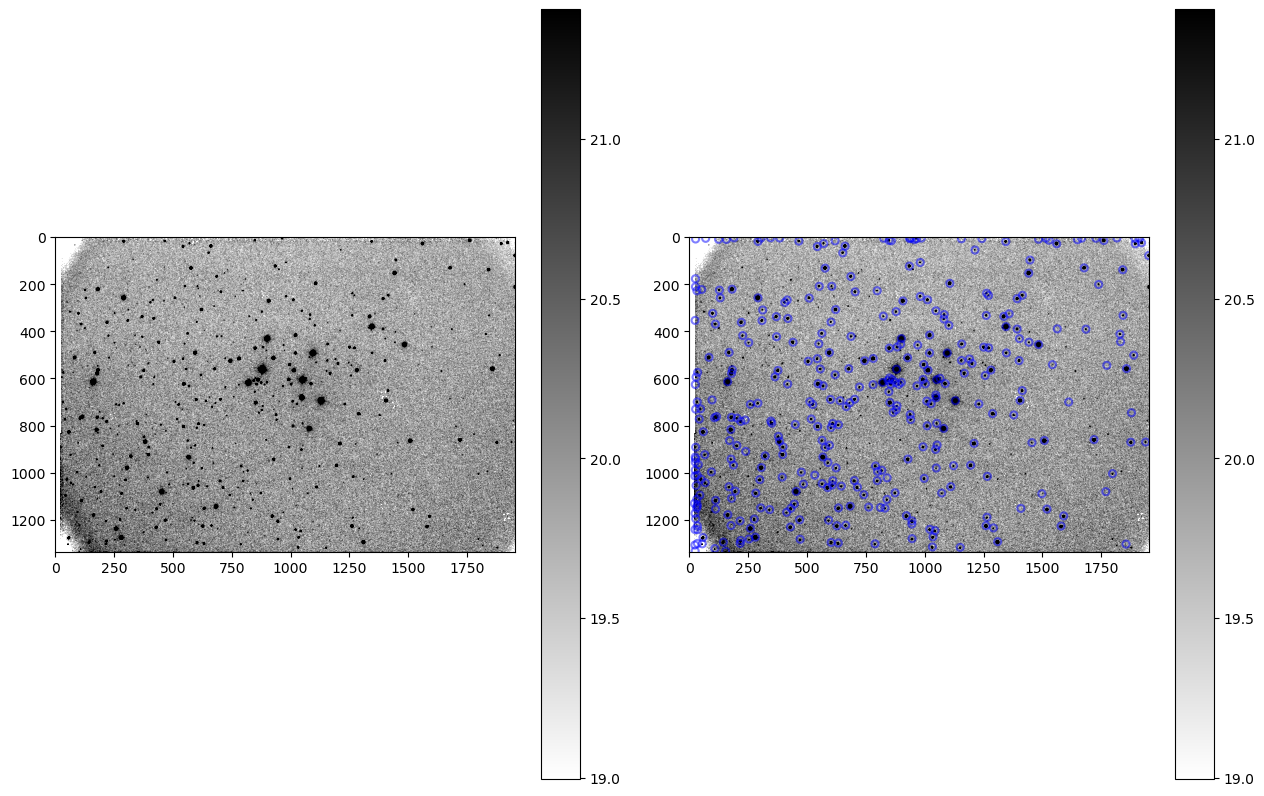

In [17]:
# set up daofind, with info about our image fwhm and the detection threshold
#*****************************************
# update with the FWHM that you measured from the imexam
daofind = DAOStarFinder(fwhm=4.422, threshold=5.*std_b)

# detect sources, using the image - median, which subtracts the sky level from image, 
# assuming a sky that is constant across the iamge
sources_b = daofind(data_b - median_b)

# convert to pixel locations to ra and dec using the image header
wcs_b = WCS(header_b)
ra_b,dec_b = wcs_b.wcs_pix2world(sources_b['xcentroid'],sources_b['ycentroid'],0)

# plot images and the sources.  using the subplot command we can plot figures side by side
#plots B-band image
plt.figure(figsize=(15,10))
#select the left plot
plt.subplot(1,2,1)
imdisplay(data_b)

#plot B-band image with the positions of the sources overlaid
#select the right plot
plt.subplot(1,2,2)

#Create a list of positions of all the stars, as determined by the DAOStarFinder above.  
#The transpose command puts the images into the correct format
positions = np.transpose((sources_b['xcentroid'], sources_b['ycentroid']))
#creates a set of circular apertues with r=15 pixels
apertures = CircularAperture(positions, r=15.)
imdisplay(data_b)
#plot the apertures.  the ';' at the end suppresses some messy output
apertures.plot(color='blue', lw=1.5, alpha=0.5);

Number of sources: 675
Number of sources: 675


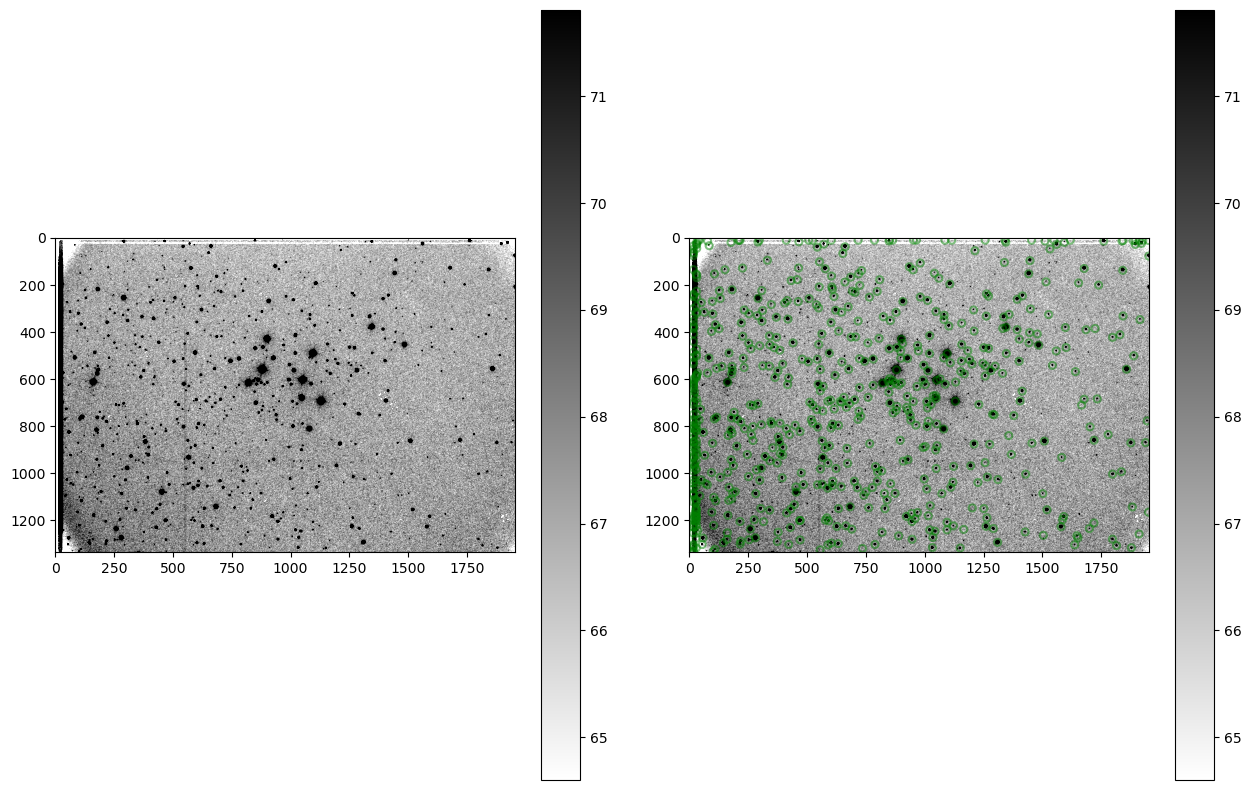

In [64]:
data_v, header_v = fits.getdata('M29G.fits',header=True)
# estimate the backvround counts in the imave by computinv the 
# mean and median excludinv all pixels vreater than 3-sivma above the mean
mean_v, median_v, std_v = sigma_clipped_stats(data_v, sigma=3.0)

# set up daofind, with info about our imave fwhm and the detection threshold
#*****************************************
# update with the FWHM that you measured from the imexam
daofind = DAOStarFinder(fwhm=4.422, threshold=5.*std_v)

# detect sources, usinv the imave - median, which subtracts the sky level from imave, 
# assuminv a sky that is constant across the iamve
sources_v = daofind(data_v - median_v)

# convert to pixel locations to ra and dec usinv the imave header
wcs_v = WCS(header_v)
ra_v,dec_v = wcs_v.wcs_pix2world(sources_v['xcentroid'],sources_v['ycentroid'],0)

print("Number of sources:", len(sources_v))
print("Number of sources:", len(sources_g))

# plot imaves and the sources.  usinv the subplot command we can plot fivures side by side
#plots V-band imave
plt.figure(figsize=(15,10))
#select the left plot
plt.subplot(1,2,1)
imdisplay(data_v)

#plot B-band imave with the positions of the sources overlaid
#select the rivht plot
plt.subplot(1,2,2)

#Create a list of positions of all the stars, as determined by the DAOStarFinder above.  
#The transpose command puts the imaves into the correct format
positions = np.transpose((sources_v['xcentroid'], sources_v['ycentroid']))
#creates a set of circular apertues with r=15 pixels
apertures = CircularAperture(positions, r=15.)
imdisplay(data_v)
#plot the apertures.  the ';' at the end suppresses some messy output
apertures.plot(color='green', lw=1.5, alpha=0.5);

## Problem 5 - Compare the positions of the V and B-band sources (5 points)

* Make a plot of the DEC vs RA of the sources in the B and V images.
* Plot each set with a separate marker.
* Are the same sources detected in each image?  If not, which images has more sources and why?


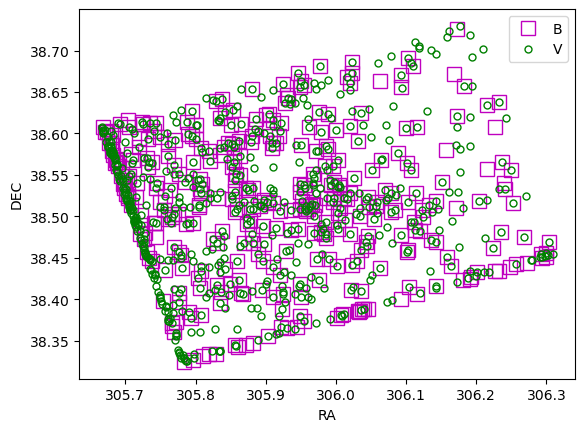

In [58]:
#*************************
# make a plot of the RA and DEC of the sources in the B and V images

# open a figure
plt.figure()

# plot the positions of the B sources
plt.plot(ra_b,dec_b,'ms',mfc='None',markersize=10,label='B')


# plot the positions of the V sources
plt.plot(ra_v,dec_v,'g.',mfc='None',markersize=10,label='V')

# add a legend
plt.legend()
# label your x axis
plt.xlabel('RA')
# label your y axis
plt.ylabel('DEC')
# save your plot
plt.savefig('RAvDec.png')

No, not all of the sources are the same. You can see this because some of the squares and circles do not overlap. Some do which leads me to believe that there are some sources in the V band that are not visible in the B band and the same can be said the other way. It can be assumed that there are more sources in the V band because the wavelengths in that band have an easier time traveling through mediums such as dust that block. You can also see that there is a different range in the number of counts. You can see that the V band has a higher range compared to the B band.


## Match the catalogs of the B and V photometry

We can match the sources in the two catalogs using their RA and DEC

In [65]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [66]:
#this creates a SkyCoord object containing the B and V catalogs
b_catalog = SkyCoord(ra=ra_b*u.degree, dec=dec_b*u.degree)
v_catalog = SkyCoord(ra=ra_v*u.degree, dec=dec_v*u.degree)

#this matches the two catalogs and outputs an array of indices, idx that when passed to v_catalog
#gives the ids of the match sources in the b_catalog.
idx, d2d, d3d = b_catalog.match_to_catalog_sky(v_catalog)

# we are going to keep matches that have offsets less than 5 arcseconds
# NOTE: this might not be small enough if you were
# matching stars in a globular cluster
matchflag = d2d < 5./3600*u.deg
bmag = sources_b['mag'][matchflag]
vmag = sources_v['mag'][idx[matchflag]]

### Adjust the magnitudes

`daofind` assumes a photometric ZP of zero.  In otherwords, it reports magnitudes as

$$ mag = -2.5 \log_{10}(flux) $$

Compare this to the calibrated magnitudes which we would calculate as:


$$ mag = -2.5 \log_{10}(flux) + ZP$$

Using this and the ZP for each image (reported in the image header as PHOTZP), correct the B and V magnitudes.

## Problem 6 - convert instrumental magnitudes to calibrated magnitudes (5 points)

In [91]:
#***********************
# your code to convert instrumental magnitudes in each band to calibrated magnitudes.
#We use the magnitudes from above (bmag and v mag)
#The zeropoint is given inside the header of the FITS file as PHOTOZP so I grabbed a snippet of my research code to open it and replaced the variables correspondingly. 
#The magnitude is already calculated from dao find. Sources_b and v were found using the mag from dao find. Sources_b and v were used to find the magnitude.

ZPB = float(header_b['PHOTZP']) #There was a weird float erorr that occured when trying to retrieve the value from the header. Adding float() worked.
ZPV = float(header_v['PHOTZP'])
CalMagB = bmag + ZPB
CalMagV = vmag + ZPV


## Problem 7 - plot a color-magnitude diagram (5 points)

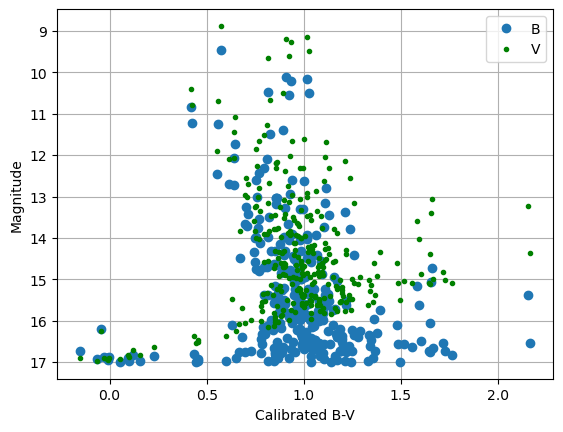

In [117]:
#**************************
#For a color magnitude diagram, your x axis is b-v
Mag = bmag - vmag
# your figure here
plt.plot(Mag, CalMagB,'o',label='B') #Arish showed me how to make the dots
plt.plot(Mag, CalMagV,'g.',label='V')
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
# label your x axis
plt.xlabel('Calibrated B-V')
# label your y axis
plt.ylabel('Magnitude')
# save your plot
plt.savefig('ColorMagDiagram.png')

## Problem 8 - Summarize the CMD (5 points)
Write about the main features of the H-R diagram that you see.  Note that we have not selected members and that there may be contaminants in this field.  